In [1]:
import dataloader
import sys
import time
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import gc

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Flatten

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

%load_ext autoreload
%autoreload 2

path = "../032721Comparison/Data/SONY2021.csv"
date = datetime.datetime(2021,3,12)
count = 1200
# We will use the previous 60 days as features
history_size = 60

In [2]:
# Compute MAE
def mae(y_hat, y):
    # mean absolute error
    return np.abs(y_hat - y).mean()

def rmse(y_hat, y):
    # root mean squared error
    return np.sqrt(np.mean(np.power((y-y_hat),2)))

In [3]:
df = dataloader.load_data_up_to_date(path, date, count)

(1258, 7)
(1257, 7)
(1257, 7)
(1200, 7)


In [4]:
sony_closing_all = df['Close'].to_numpy()
# reshape to 1200 x 1 matrix
sony_closing_all = np.reshape(sony_closing_all, (sony_closing_all.shape[0], -1))
sony_closing_all.shape

(1200, 1)

In [5]:
#converting prices to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sony_closing_all)
train = scaled_data[:1000,:]
test = scaled_data[1000:, :]

In [6]:
train_x, train_y = [], []
test_x, test_y = [], []
for i in range(history_size,len(train)):
    train_x.append(scaled_data[i-history_size:i,0])
    train_y.append(scaled_data[i,0])
train_x, train_y = np.array(train_x), np.array(train_y)

train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1], 1))
print(train_x.shape)

for i in range(len(train),len(scaled_data)):
    test_x.append(scaled_data[i-history_size:i,0])
    test_y.append(scaled_data[i,0])
test_x, test_y = np.array(test_x), np.array(test_y)

test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1], 1))
print(test_x.shape)



(940, 60, 1)
(200, 60, 1)


In [7]:
# How many features do we want to pass as hidden unit
UNITS = range(2, 60, 2)
K = 5
model = None
gc.collect()

best_unit_count = None
# Best Validation Error
best_err = sys.maxsize

for unit_count in UNITS:
    kf = KFold(n_splits=K, random_state=None, shuffle=False)
    y_err = []
    
    
    # Cross Validaiton
    for train_index, val_index in kf.split(train_x):
        X_train, X_val = train_x[train_index], train_x[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
    
        model = Sequential()
        model.add(LSTM(units=unit_count, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(RepeatVector(X_train.shape[1]))
        model.add(LSTM(units=unit_count, return_sequences=True))
        model.add(Flatten())
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
        y_hat = model.predict(X_val).transpose()[0]
        del model
        gc.collect()
        
        y_err.append(rmse(y_hat, y_val))
        
    print(str(unit_count), "mean val RMSE:", np.mean(y_err))

    if np.mean(y_err) < best_err:
        best_err = np.mean(y_err)
        best_unit_count = unit_count

print(best_unit_count, best_err)

2 mean val RMSE: 0.07995036620995398
4 mean val RMSE: 0.08963994581343841
6 mean val RMSE: 0.060666998960439325
8 mean val RMSE: 0.03784023282352606
10 mean val RMSE: 0.05084157656305756
12 mean val RMSE: 0.049100344275997146
14 mean val RMSE: 0.03321489315470432
16 mean val RMSE: 0.01994110260737917
18 mean val RMSE: 0.030657696748834097
20 mean val RMSE: 0.030427942202876916
22 mean val RMSE: 0.04186572099767425
24 mean val RMSE: 0.03250775645936892
26 mean val RMSE: 0.029753944666391058
28 mean val RMSE: 0.042834519899987475
30 mean val RMSE: 0.04331082398183022
32 mean val RMSE: 0.02996430136025761
34 mean val RMSE: 0.025381608899220066
36 mean val RMSE: 0.03329125332386641
38 mean val RMSE: 0.024374336398380127
40 mean val RMSE: 0.026728002965383836
42 mean val RMSE: 0.030438392172348682
44 mean val RMSE: 0.0259133330896248
46 mean val RMSE: 0.029622147020002997
48 mean val RMSE: 0.025259523570037423
50 mean val RMSE: 0.030343374437173703
52 mean val RMSE: 0.0359427015114163
54 me

In [8]:
model = None
gc.collect()

model = Sequential()
model.add(LSTM(units=best_unit_count, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(units=best_unit_count, return_sequences=True))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=100, batch_size=32, verbose=1)
print(model.summary())
y_hat = model.predict(test_x).transpose()[0]

del model
gc.collect()

Epoch 1/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0074
Epoch 2/100
30/30 [==============================] - 0s 7ms/step - loss: 3.8521e-04
Epoch 3/100
30/30 [==============================] - 0s 12ms/step - loss: 1.9831e-04
Epoch 4/100
30/30 [==============================] - 0s 12ms/step - loss: 1.7977e-04
Epoch 5/100
30/30 [==============================] - 0s 12ms/step - loss: 1.7709e-04
Epoch 6/100
30/30 [==============================] - 0s 12ms/step - loss: 1.7935e-04
Epoch 7/100
30/30 [==============================] - 0s 12ms/step - loss: 1.7439e-04
Epoch 8/100
30/30 [==============================] - 0s 12ms/step - loss: 1.7519e-04
Epoch 9/100
30/30 [==============================] - 0s 12ms/step - loss: 1.7411e-04
Epoch 10/100
30/30 [==============================] - 0s 12ms/step - loss: 1.7270e-04
Epoch 11/100
30/30 [==============================] - 0s 12ms/step - loss: 1.6519e-04
Epoch 12/100
30/30 [==============================] - 0s 12ms/step - 

30/30 [==============================] - 0s 12ms/step - loss: 1.1939e-04
Epoch 97/100
30/30 [==============================] - 0s 12ms/step - loss: 1.2616e-04
Epoch 98/100
30/30 [==============================] - 0s 12ms/step - loss: 1.4369e-04
Epoch 99/100
30/30 [==============================] - 0s 12ms/step - loss: 2.0093e-04
Epoch 100/100
30/30 [==============================] - 0s 12ms/step - loss: 1.6186e-04
Model: "sequential_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_290 (LSTM)              (None, 16)                1152      
_________________________________________________________________
repeat_vector_145 (RepeatVec (None, 60, 16)            0         
_________________________________________________________________
lstm_291 (LSTM)              (None, 60, 16)            2112      
_________________________________________________________________
flatten_145 (Flatten)        (

39010

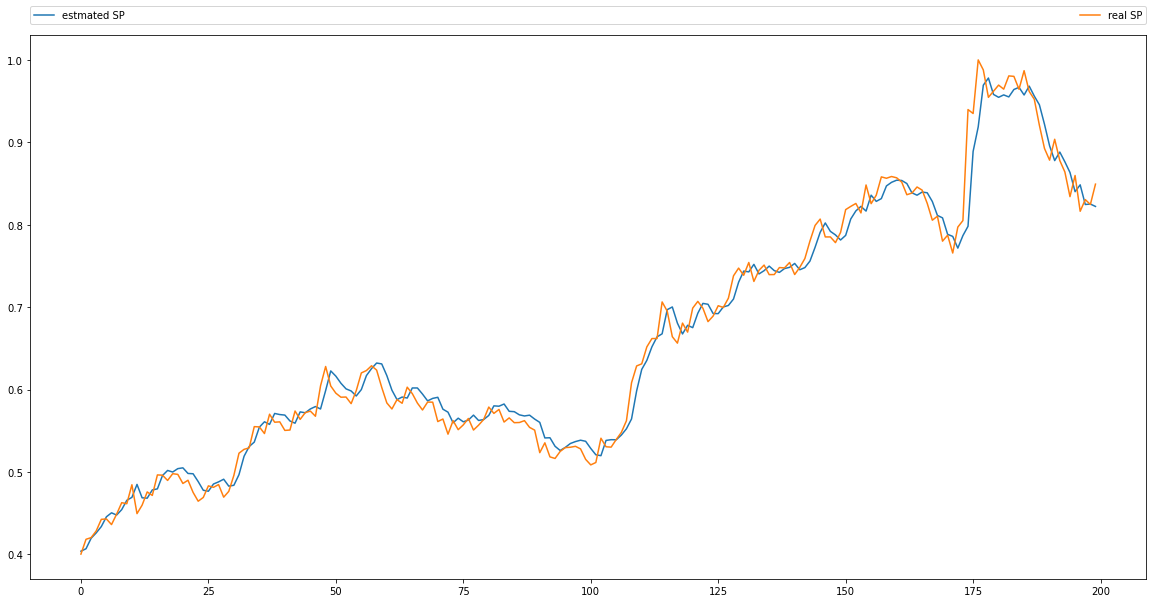

In [9]:
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [10]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.01395662985937595
RMSE:  0.019874325864895508
